In [1]:
import re
import random
import pandas as pd
import hashlib

In [2]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)



cards_to_age['head'] = cards_to_age['head'].str.strip()

# remove headers I don't want anymore
undesired_headers = ['CCH Axcess']
cards_to_age = cards_to_age.loc[~cards_to_age['head'].isin(undesired_headers), :].copy()

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.5) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.3) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.075

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())
cards_to_age['head_count'] = cards_to_age.groupby('head')['head'].transform("count")


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [3]:
ave_order = ('age', 'mean')
sum_order = ('age', 'sum')

stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(ave_order)
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Node.JS and React,607.433425,19.594627,29.730518,31
"Mexican Gothic, Moreno-Garcia",968.394077,34.585503,59.547335,28
Azure Functions Core Tools,660.819037,38.871708,53.796496,17
C# Basics,51.324580,51.324580,51.324580,1
Django,2305.402132,57.635053,78.616443,40
Node.js and Vite,2389.400579,58.278063,85.560415,41
Python,5186.214244,66.489926,181.043338,78
Azure Files Documentation,4244.832001,70.747200,159.026015,60
Active Directory and Azure Files,2838.637517,76.719933,117.570112,37
CCH Tax Forms Project,1663.667676,79.222270,150.669647,21


# Histogram

sum of ages: ~52720.22


<Axes: >

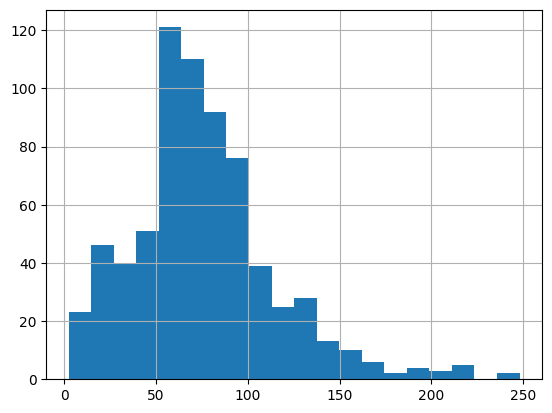

In [4]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~52720.22


<Axes: >

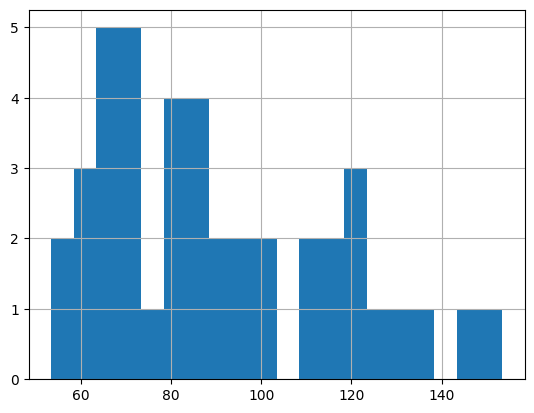

In [5]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Terraform Codebox']['age'].hist(bins=20)

# Completely Random Shuffle

In [6]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [7]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# N-fold shuffle


## Age Sum

In [8]:
# n = 3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [9]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [10]:
n = 5
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] // n

if existing_cards['age'].sum() > 0:
    existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
    existing_cards['neg_age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# existing_cards.sort_values(['age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


Cards found: 696
Total card age: 52720.22


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
19,Power BI,Why can’t you reference a newly added column a...,a550364578e3469f2990bdec6904efc0,248.002911,101.429639,-248.002911,3245.748433,0.949585,32,0,0,-248.002911
263,Power BI,Q: How can you verify gateway-related issues a...,435f9629e7b1f400570a9e3621203c73,199.564941,101.429639,-248.002911,3245.748433,0.949585,32,1,0,-199.564941
498,Power BI,Q: How can using the “Enable Load of Related E...,da5bedb14955d2ace07ea2a5e14706ee,165.045695,101.429639,-248.002911,3245.748433,0.949585,32,2,0,-165.045695
20,Power BI,Q: How can you increase the SQL connector’s co...,d42494b02bec57d671886de94929de78,141.800832,101.429639,-248.002911,3245.748433,0.949585,32,3,0,-141.800832
264,Power BI,"Q: If you freeze only half your rows (e.g., 10...",65859587f03c52c2979d3b2de698fa86,139.254171,101.429639,-248.002911,3245.748433,0.949585,32,4,0,-139.254171
2,JavaScript Concepts,Generate distinct arrays with fill() + map()\n...,1c477652c74da3a626b132108ec4229f,237.708727,103.080171,-237.708727,5154.008548,0.460385,50,0,0,-237.708727
246,JavaScript Concepts,Express.js: A minimalist web framework for Nod...,425c10164d26897fdad3f9d7c2c6f523,219.355808,103.080171,-237.708727,5154.008548,0.460385,50,1,0,-219.355808
482,JavaScript Concepts,Many operators coerce the operands into number...,c7910dc971abc5da390f0193c2ffbdc8,211.747785,103.080171,-237.708727,5154.008548,0.460385,50,2,0,-211.747785
3,JavaScript Concepts,Arrow Functions: Arrow functions provide a con...,2e3769781211a560564f81d13f2051b9,199.501926,103.080171,-237.708727,5154.008548,0.460385,50,3,0,-199.501926
247,JavaScript Concepts,Logical AND (&&) and OR (||) Statements\nif (c...,8541c9ae716e3f5474869ab92784fcc8,197.558446,103.080171,-237.708727,5154.008548,0.460385,50,4,0,-197.558446


## Card Count

In [11]:
# n=5
# # existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
#     existing_cards['subject_highest_age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_count', 'subject_highest_age', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [12]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [13]:
existing_cards.head(10)['age'].sum()

np.float64(1959.5412431036034)

In [14]:
asc = existing_cards.age.sum() < 0

existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
19,Power BI,Why can’t you reference a newly added column a...,a550364578e3469f2990bdec6904efc0,248.002911,101.429639,-248.002911,3245.748433,0.949585,32,0,0,-248.002911
2,JavaScript Concepts,Generate distinct arrays with fill() + map()\n...,1c477652c74da3a626b132108ec4229f,237.708727,103.080171,-237.708727,5154.008548,0.460385,50,0,0,-237.708727
237,PnP PowerShell,REST API Endpoints\nSpecific URLs used to acce...,b12f5012328f32a6c689485970705806,223.089108,96.708373,-223.089108,1934.167469,0.910065,20,0,0,-223.089108
246,JavaScript Concepts,Express.js: A minimalist web framework for Nod...,425c10164d26897fdad3f9d7c2c6f523,219.355808,103.080171,-237.708727,5154.008548,0.460385,50,1,0,-219.355808
92,Microsoft Purview,"When you create your DLP policies, you should ...",8ec1edc0f421bb7de2884cb3c7089b3e,218.451280,80.807530,-218.451280,4040.376504,0.779463,50,0,0,-218.451280
30,Vocab,"Something Rotten, Fforde\nSalver\nnoun | SAL-v...",c8d10134bc737eb530dfa3f6d3e44e00,212.058704,98.300262,-212.058704,2162.605761,0.283399,22,0,0,-212.058704
482,JavaScript Concepts,Many operators coerce the operands into number...,c7910dc971abc5da390f0193c2ffbdc8,211.747785,103.080171,-237.708727,5154.008548,0.460385,50,2,0,-211.747785
334,Microsoft Purview,Run the policy in simulation mode with notific...,3a95ac540d1e377383ba60aeb1da4f08,200.717183,80.807530,-218.451280,4040.376504,0.779463,50,1,0,-200.717183
263,Power BI,Q: How can you verify gateway-related issues a...,435f9629e7b1f400570a9e3621203c73,199.564941,101.429639,-248.002911,3245.748433,0.949585,32,1,0,-199.564941
3,JavaScript Concepts,Arrow Functions: Arrow functions provide a con...,2e3769781211a560564f81d13f2051b9,199.501926,103.080171,-237.708727,5154.008548,0.460385,50,3,0,-199.501926


In [15]:
f"Average age: {abs(existing_cards['age'].mean()):.3f}"

'Average age: 75.747'